assumption of normally distributed returns is fundamental to the theory
By looking only at mean and variance, we are assuming that no other statistics are necessary to describe the distribution of end of period wealth. Unless investors have a special type fo utility function (quadratic utility function), it is necessary to assume that returns have a normal distribution, which can be completely described by mean and variance. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()
raw.head(10)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.880,133.900,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.870,134.690,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.800,132.250,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.600,130.000,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.830,133.520,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
2010-01-11,30.015684,30.270,20.950,130.308,171.56,114.73,1146.98,17.55,1.4513,1152.60,50.17,112.85
2010-01-12,29.674256,30.070,20.608,127.350,167.82,113.66,1136.22,18.25,1.4494,1127.30,48.35,110.49
2010-01-13,30.092827,30.350,20.960,129.110,169.07,114.62,1145.68,17.85,1.4510,1138.40,48.86,111.54
2010-01-14,29.918542,30.960,21.480,127.350,168.53,114.93,1148.46,17.63,1.4502,1142.85,48.60,112.03


array([[<Axes: title={'center': 'AAPL.O'}>,
        <Axes: title={'center': 'MSFT.O'}>],
       [<Axes: title={'center': 'SPY'}>, <Axes: title={'center': 'GLD'}>]],
      dtype=object)

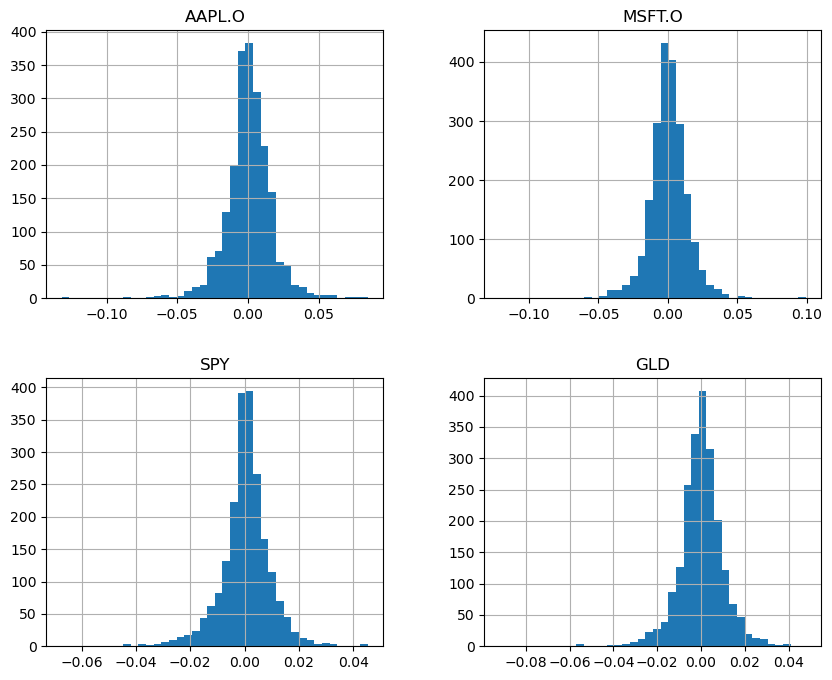

In [3]:
symbols = ['AAPL.O', 'MSFT.O', 'SPY', 'GLD']
noa = len(symbols)
data = raw[symbols]
rets = np.log(data / data.shift(1))
rets.hist(bins=40, figsize=(10,8))


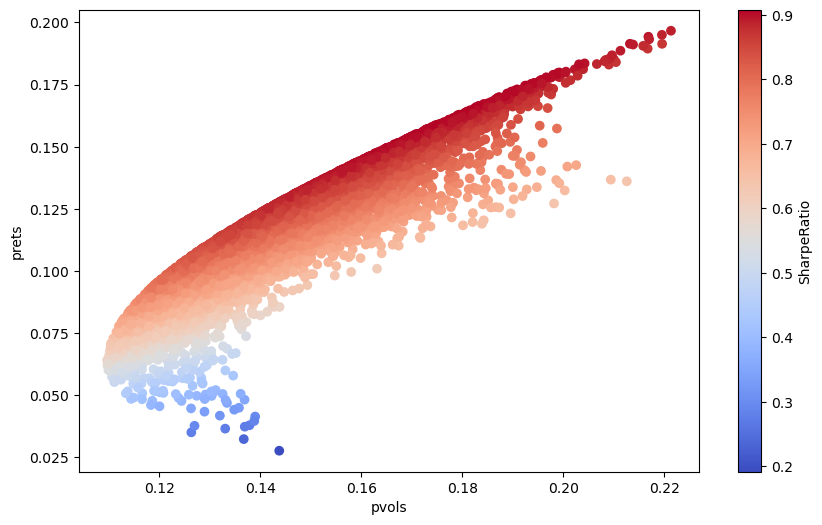

In [4]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 255
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

pvols = []
prets = []
for i in range(10000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    pvols.append(port_vol(weights))
    prets.append(port_ret(weights))
pvols = np.array(pvols)
prets = np.array(prets)

plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm')
plt.xlabel('pvols')
plt.ylabel('prets')
plt.colorbar(label='SharpeRatio')


In [5]:
# efficient frontier

def min_sharpe_ratio(weights):
    return -port_ret(weights) / port_vol(weights)

con = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnd = tuple((0,1) for _ in range(noa))

eweights = np.array(noa * [1/noa])
import scipy.optimize as sco
opts = sco.minimize(min_sharpe_ratio, eweights, method='SLSQP', constraints=con, bounds=bnd)
opts['x'].round(3)






array([0.512, 0.191, 0.254, 0.042])

In [6]:
optv = sco.minimize(port_vol, eweights, method='SLSQP', constraints=con, bounds=bnd)
optv['x'].round(3)

array([0.   , 0.001, 0.543, 0.456])

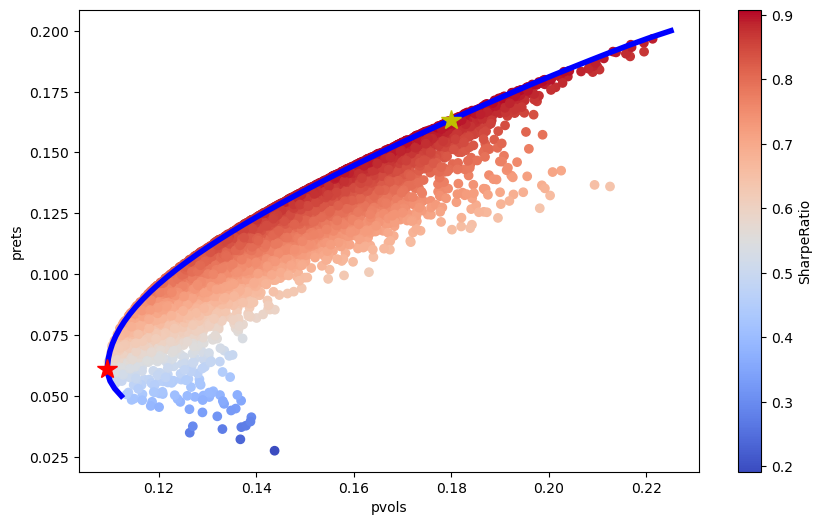

In [7]:
cons = ({'type':'eq', 'fun': lambda x: port_ret(x) - tret},
        {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for _ in range(noa))

trets = np.linspace(.05,.2,50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', constraints=cons, bounds=bnds)
    tvols.append(res['fun'])
tvols = np.array(tvols)

plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm')

plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)


plt.xlabel('pvols')
plt.ylabel('prets')
plt.colorbar(label='SharpeRatio')
